In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt

In [33]:
data_rnn= pd.read_csv("archive/daily/AALI.csv")
data_rnn['timestamp'] = pd.to_datetime(data_rnn['timestamp'])
data_rnn.set_index('timestamp', inplace=True)
data_rnn.head()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,524,524,547,547,342131
2001-04-17,547,524,571,524,345804
2001-04-18,547,524,547,524,230361
2001-04-19,524,500,524,500,457574
2001-04-20,476,452,476,452,228262


In [34]:
data_rnn.isna().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_rnn = scaler.fit_transform(data_rnn)

In [36]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # Close price is the target
    return np.array(sequences), np.array(targets)

In [37]:
seq_length = 60
sequences, targets = create_sequences(scaled_data_rnn, seq_length)

In [38]:
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

In [39]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 5)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

f:\KULIAH\SEM 4\MachineLearning\FinalProject\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0262 - val_loss: 3.4829e-04
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0032 - val_loss: 5.6366e-04
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0027 - val_loss: 2.8853e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0024 - val_loss: 3.9724e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0023 - val_loss: 2.3924e-04
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0021 - val_loss: 2.4637e-04
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0022 - val_loss: 2.4482e-04
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0018 - val_loss: 2.3776e-04
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0019 - val_loss: 2.2339e-04
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0017 - val_loss: 2.4174e-04


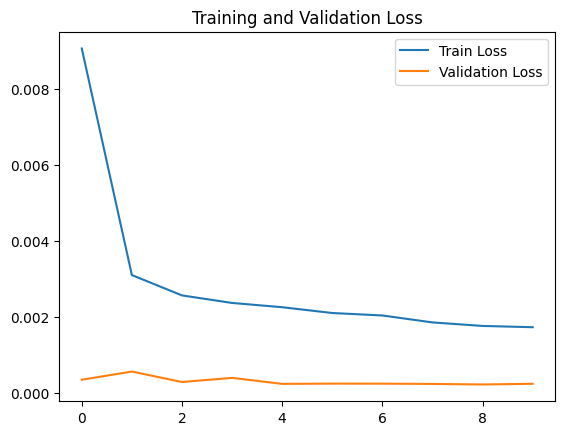

In [42]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [43]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [44]:
combined_train_test_predictions = np.concatenate((train_predictions, test_predictions), axis=0)
combined_train_test_actual = np.concatenate((y_train, y_test), axis=0)

In [45]:
mse_normalized = mean_squared_error(combined_train_test_actual, combined_train_test_predictions)
mape_normalized = mean_absolute_percentage_error(combined_train_test_actual, combined_train_test_predictions)
r2_normalized = r2_score(combined_train_test_actual, combined_train_test_predictions)

print(f'Normalized Data Metrics:')
print(f'MSE: {mse_normalized}')
print(f'MAPE: {mape_normalized}')
print(f'R2 Score: {r2_normalized}')

Normalized Data Metrics:
MSE: 0.0004599120597814801
MAPE: 0.0545161901240491
R2 Score: 0.9917022266519998


In [46]:
train_predictions_scaled = np.zeros((train_predictions.shape[0], 5))
train_predictions_scaled[:, 3] = train_predictions[:, 0]  # Place predictions in the 'close' column
train_predictions = scaler.inverse_transform(train_predictions_scaled)[:, 3]

test_predictions_scaled = np.zeros((test_predictions.shape[0], 5))
test_predictions_scaled[:, 3] = test_predictions[:, 0]  # Place predictions in the 'close' column
test_predictions = scaler.inverse_transform(test_predictions_scaled)[:, 3]

In [47]:
y_train_scaled = np.zeros((y_train.shape[0], 5))
y_train_scaled[:, 3] = y_train  # Place true values in the 'close' column
y_train_actual = scaler.inverse_transform(y_train_scaled)[:, 3]

y_test_scaled = np.zeros((y_test.shape[0], 5))
y_test_scaled[:, 3] = y_test  # Place true values in the 'close' column
y_test_actual = scaler.inverse_transform(y_test_scaled)[:, 3]

In [48]:
combined_train_predictions = np.concatenate((train_predictions, test_predictions[:0]), axis=0)
combined_test_predictions = np.concatenate((train_predictions[:0], test_predictions), axis=0)

In [49]:
combined_train_actual = np.concatenate((y_train_actual, y_test_actual[:0]), axis=0)
combined_test_actual = np.concatenate((y_train_actual[:0], y_test_actual), axis=0)

In [50]:
mse_denormalized = mean_squared_error(y_test_actual, test_predictions)
mape_denormalized = mean_absolute_percentage_error(y_test_actual, test_predictions)
r2_denormalized = r2_score(y_test_actual, test_predictions)

print(f'Denormalized Data Metrics:')
print(f'MSE: {mse_denormalized}')
print(f'MAPE: {mape_denormalized}')
print(f'R2 Score: {r2_denormalized}')

Denormalized Data Metrics:
MSE: 246679.43323957952
MAPE: 0.03904781721371088
R2 Score: 0.9261565625068247


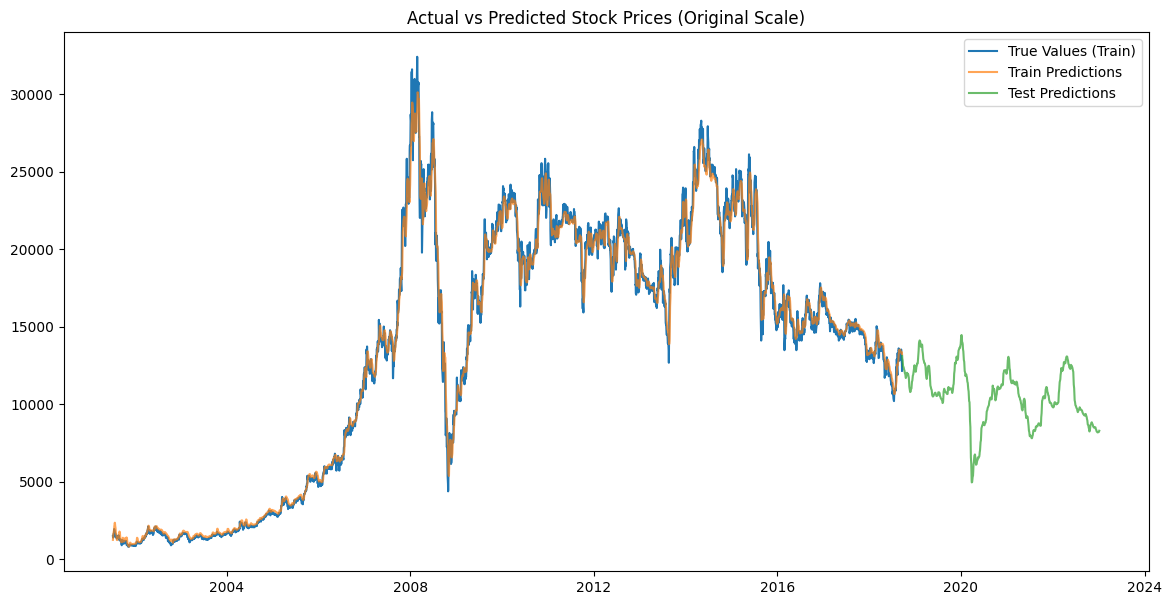

In [51]:
plt.figure(figsize=(14, 7))
plt.plot(data_rnn.index[seq_length:seq_length+len(combined_train_actual)], combined_train_actual, label='True Values (Train)')
plt.plot(data_rnn.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', alpha=0.7)
plt.plot(data_rnn.index[seq_length+len(train_predictions):seq_length+len(train_predictions)+len(test_predictions)], test_predictions, label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Original Scale)')
plt.show()

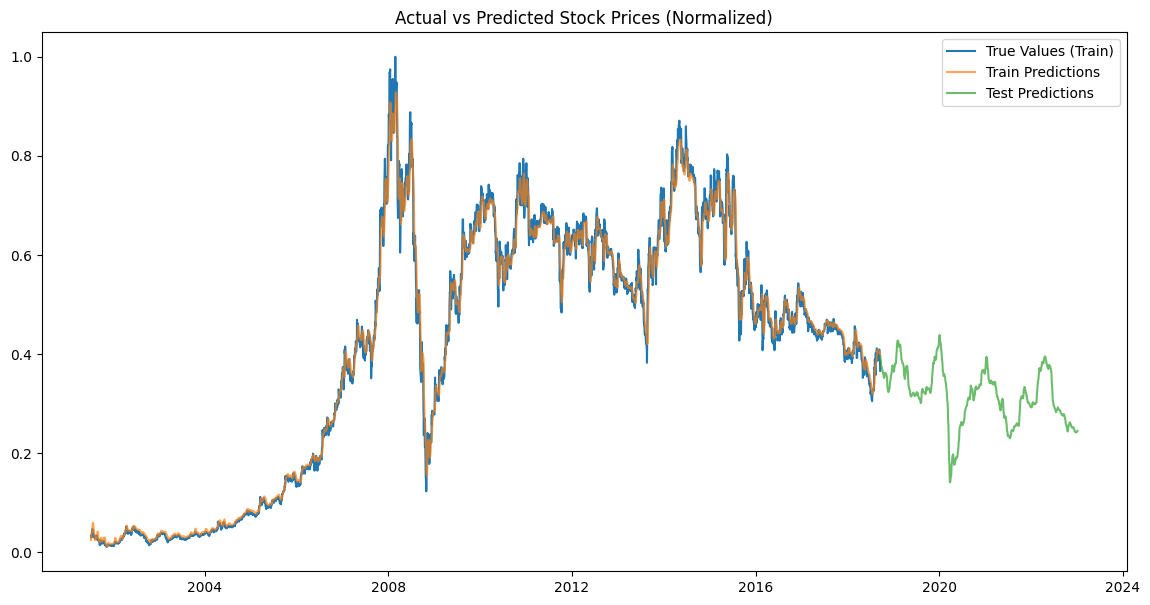

In [53]:
plt.figure(figsize=(14, 7))
plt.plot(data_rnn.index[seq_length:seq_length + len(y_train)], y_train, label='True Values (Train)')
plt.plot(data_rnn.index[seq_length:seq_length + len(train_predictions)], combined_train_test_predictions[:len(train_predictions)], label='Train Predictions', alpha=0.7)
plt.plot(data_rnn.index[seq_length + len(train_predictions):seq_length + len(train_predictions) + len(test_predictions)], combined_train_test_predictions[len(train_predictions):], label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.show()